In [1]:
import sys
sys.path.append("..")
from flame_analysis_model import *
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
torch.cuda.empty_cache()
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, KernelPCA
import torch.nn.functional as F


In [2]:
features = [
    'omega_H2', 'omega_O2', 'omega_H2O', 'omega_H', 'omega_O', 'omega_OH',
    'omega_HO2', 'omega_H2O2', 'omega_N2'
]
df = pd.read_csv("extracted_flame_front_120.csv")
colourmap = df["disp_speed_density_weighted"]
X = StandardScaler().fit_transform(df[features])

KeyError: "None of [Index(['omega_H2', 'omega_O2', 'omega_H2O', 'omega_H', 'omega_O', 'omega_OH',\n       'omega_HO2', 'omega_H2O2', 'omega_N2'],\n      dtype='object')] are in the [columns]"

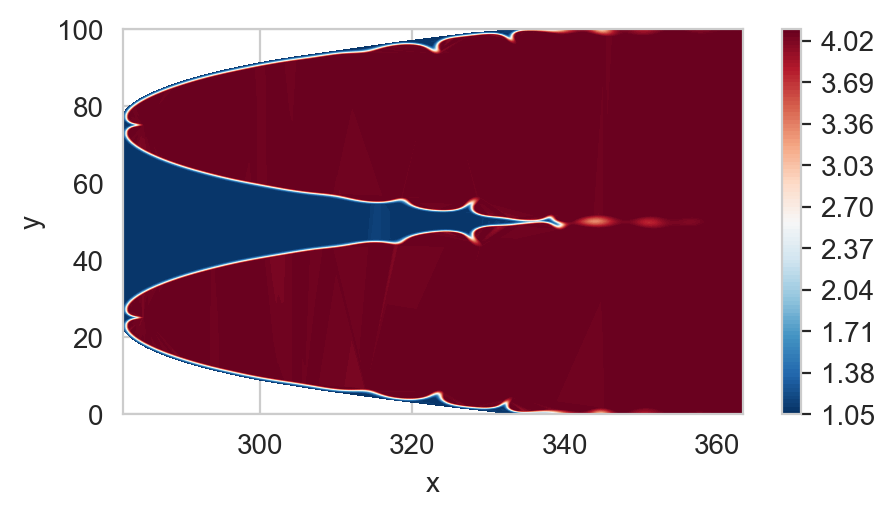

In [5]:
fig, ax = plt.subplots(figsize=(5, 2.5), dpi = 200)
c = ax.tricontourf(df["x"], df["y"] , df["T"], levels=100, cmap="RdBu_r")
fig.colorbar(c)
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

## Vanilla PCA

In [6]:
pca = PCA()
X_pca= pca.fit(X)

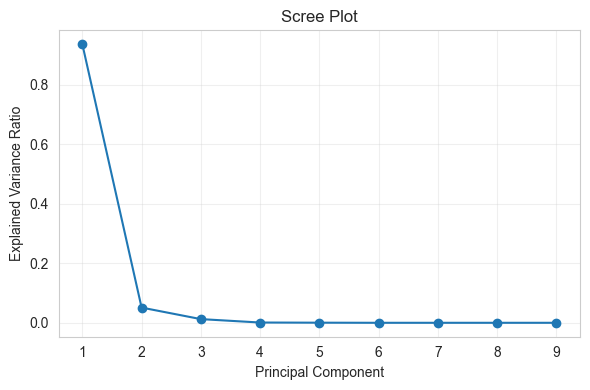

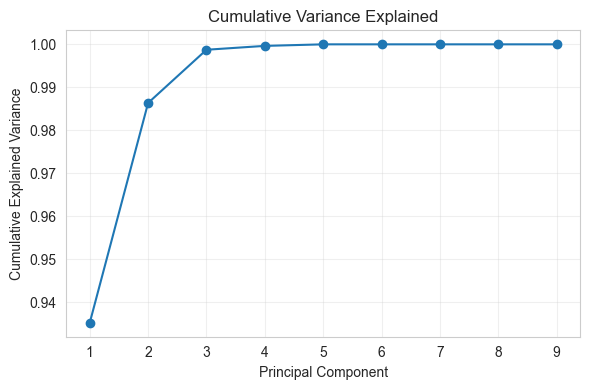

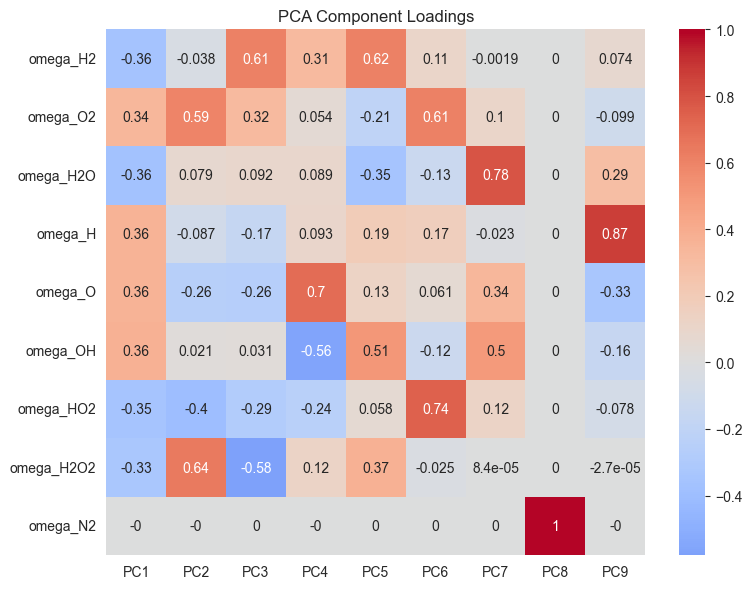

In [7]:
# PCA COMPONENT PLOTS
# ============================================================

# 1. Scree plot — explained variance per PC
plt.figure(figsize=(6, 4))
plt.plot(np.arange(1, len(pca.explained_variance_ratio_) + 1),
         pca.explained_variance_ratio_,
         marker='o')
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.title("Scree Plot")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 2. Cumulative explained variance
plt.figure(figsize=(6, 4))
plt.plot(np.arange(1, len(pca.explained_variance_ratio_) + 1),
         np.cumsum(pca.explained_variance_ratio_),
         marker='o')
plt.xlabel("Principal Component")
plt.ylabel("Cumulative Explained Variance")
plt.title("Cumulative Variance Explained")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 3. Loadings heatmap (feature contributions to each PC)
loadings = pd.DataFrame(
    pca.components_.T,
    index=features,
    columns=[f"PC{i + 1}" for i in range(len(features))]
)

plt.figure(figsize=(8, 6))
sns.heatmap(loadings, annot=True, cmap="coolwarm", center=0)
plt.title("PCA Component Loadings")
plt.tight_layout()
plt.show()


## Kernel PCA

In [ ]:
kpca = KernelPCA()
kpca.fit(X)

Number of Eigenvalues: 6


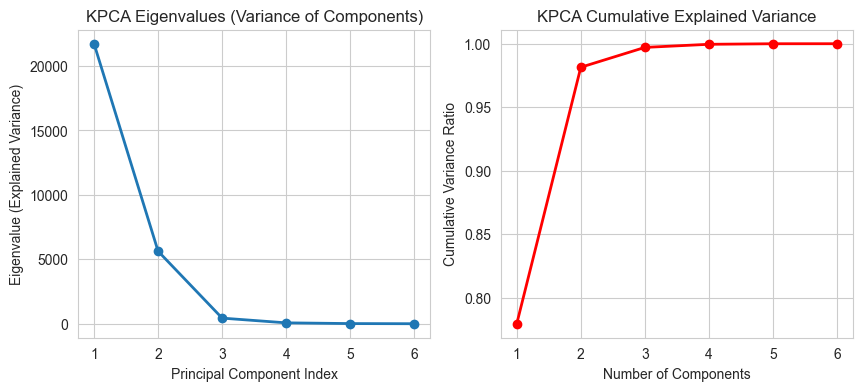

In [21]:
# PCA COMPONENT PLOTS
# ============================================================
# Get the eigenvalues (variance explained by components in feature space)
eigvals = kpca.eigenvalues_
print(f"Number of Eigenvalues: {len(eigvals)}")

# Plotting the eigenvalues (Scree Plot for KPCA)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(np.arange(1, len(eigvals) + 1), eigvals, 'o-', linewidth=2)
plt.title('KPCA Eigenvalues (Variance of Components)')
plt.xlabel('Principal Component Index')
plt.ylabel('Eigenvalue (Explained Variance)')
plt.grid(True)

# Plotting the cumulative explained variance (optional but helpful)
cumulative_variance = np.cumsum(eigvals) / np.sum(eigvals)
plt.subplot(1, 2, 2)
plt.plot(np.arange(1, len(eigvals) + 1), cumulative_variance, 'o-', linewidth=2, color='red')
plt.title('KPCA Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance Ratio')
plt.grid(True)
plt.show()



## Sparce PCA

## LVR-AE

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
if device.type == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))

Using device: cuda
GPU: NVIDIA GeForce RTX 3050 4GB Laptop GPU


Epoch 1000: rec = 0.00020342, vol = 0.10648
Epoch 2000: rec = 6.5424e-05, vol = 0.092932
Epoch 3000: rec = 4.2593e-05, vol = 0.074527
Epoch 4000: rec = 3.1451e-05, vol = 0.080594
Epoch 5000: rec = 3.4832e-05, vol = 0.069836
Epoch 6000: rec = 2.1311e-05, vol = 0.06954


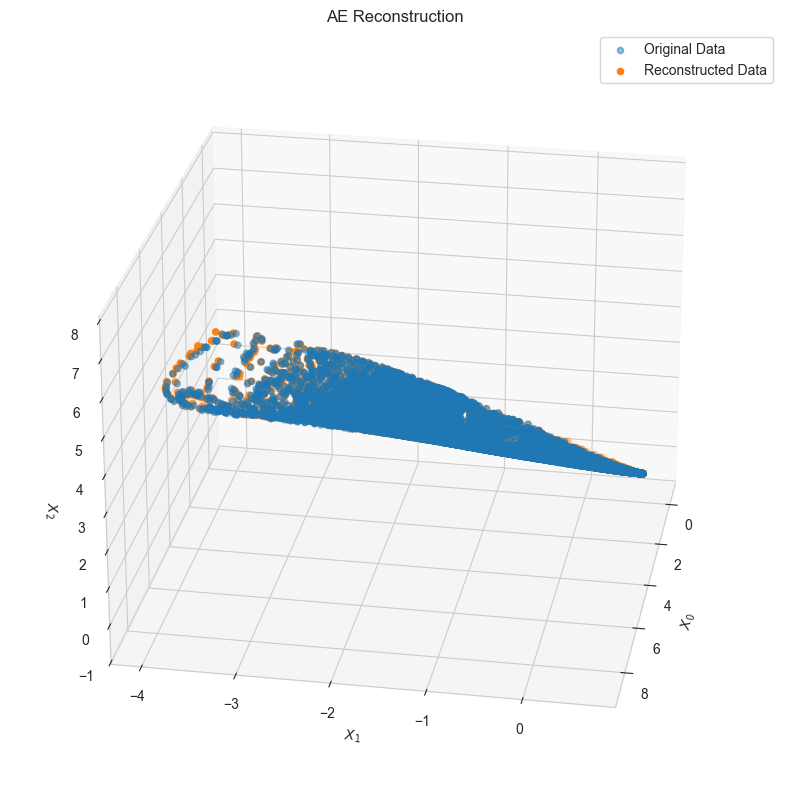

In [11]:

# Move data to GPU
ambient_dim = X.shape[1]
X_torch = torch.from_numpy(X).float().to(device)

width = ambient_dim * 16
# Define models and move to GPU
encoder = MLP(ambient_dim, ambient_dim, [width] * 4).to(device)
decoder = SNMLP(ambient_dim, ambient_dim, [width] * 4).to(device)

opt = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=1e-3)

eta, l = 0.01, 0.01

for i in range(6000):
    opt.zero_grad()
    z = encoder(X_torch)
    rec_loss = F.mse_loss(decoder(z), X_torch)
    vol_loss = torch.exp(torch.log(z.std(0) + eta).mean())
    loss = rec_loss + l * vol_loss
    loss.backward()
    opt.step()

    if (i + 1) % 1000 == 0:
        print(f'Epoch {i + 1:4}: rec = {rec_loss.item():.5g}, vol = {vol_loss.item():.5g}')

# Move data back to CPU for plotting
encoder.eval()
decoder.eval()
with torch.no_grad():
    X_P = decoder(encoder(X_torch)).cpu().numpy()

X_np = X_torch.cpu().numpy()

# Plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
ax.scatter(X_np[:, 0], X_np[:, 1], X_np[:, 2], alpha=0.5)
ax.scatter(X_P[:, 0], X_P[:, 1], X_P[:, 2])
ax.set_xlabel('$X_0$')
ax.set_ylabel('$X_1$')
ax.set_zlabel('$X_2$')
ax.elev = 25
ax.azim = 10
plt.legend(['Original Data', 'Reconstructed Data'])
plt.title("AE Reconstruction")
plt.show()
# Switch to eval mode and disable gradient tracking
encoder.eval()
decoder.eval()
with torch.no_grad():
    z = encoder(X_torch)

# Move latent vectors to CPU once and convert to NumPy
z_np = z.detach().cpu().numpy()

# Rank dimensions by standard deviation (importance)
idx = z.std(0).argsort(descending=True)



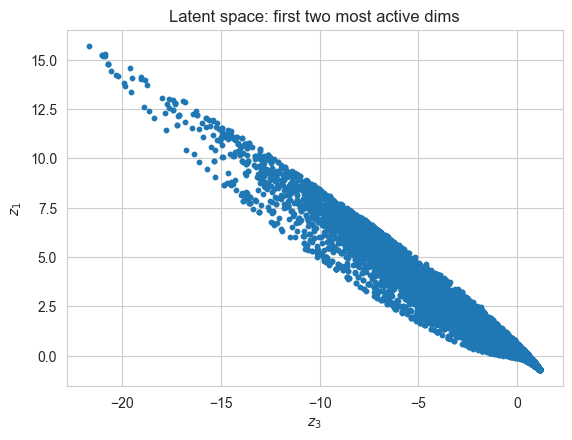

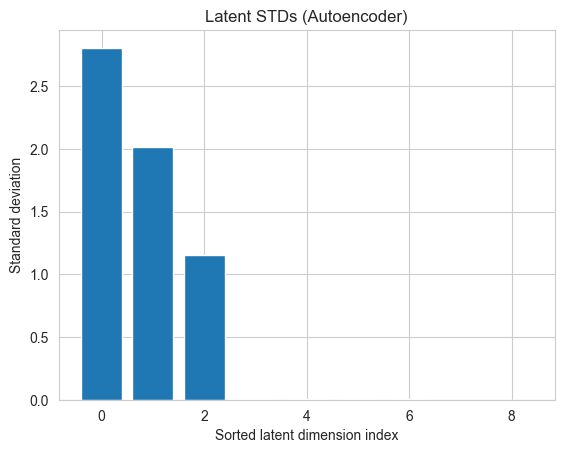

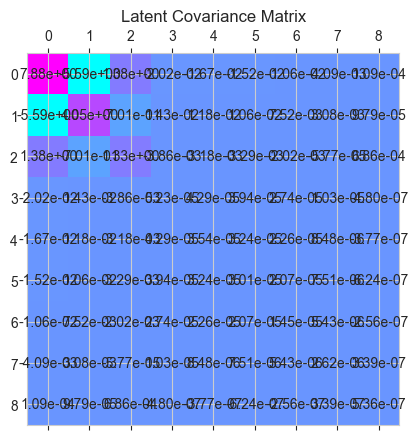

In [12]:

# ---- Plot 1: z0 vs z1 ----
plt.figure()
plt.scatter(z_np[:, idx[0]], z_np[:, idx[1]], s=10)
plt.gca().set_aspect('equal')
plt.xlabel(f'$z_{{{idx[0]}}}$')
plt.ylabel(f'$z_{{{idx[1]}}}$')
plt.title('Latent space: first two most active dims')
plt.show()


# Compute and sort latent STDs
z_std = z.std(0).detach().cpu().numpy()
idx = z.std(0).detach().cpu().argsort(descending=True)

# Plot
plt.figure()
plt.bar(np.arange(len(z_std)), z_std[idx])
plt.title('Latent STDs (Autoencoder)')
plt.xlabel('Sorted latent dimension index')
plt.ylabel('Standard deviation')
plt.show()


cov = z.T[idx].cov().detach().cpu().numpy()
plt.matshow(cov, cmap='cool')
for (i, j), var in np.ndenumerate(cov):
    plt.gca().text(j, i, '{:.2e}'.format(var), ha='center', va='center')
plt.title('Latent Covariance Matrix')
plt.show()

<Figure size 640x480 with 0 Axes>

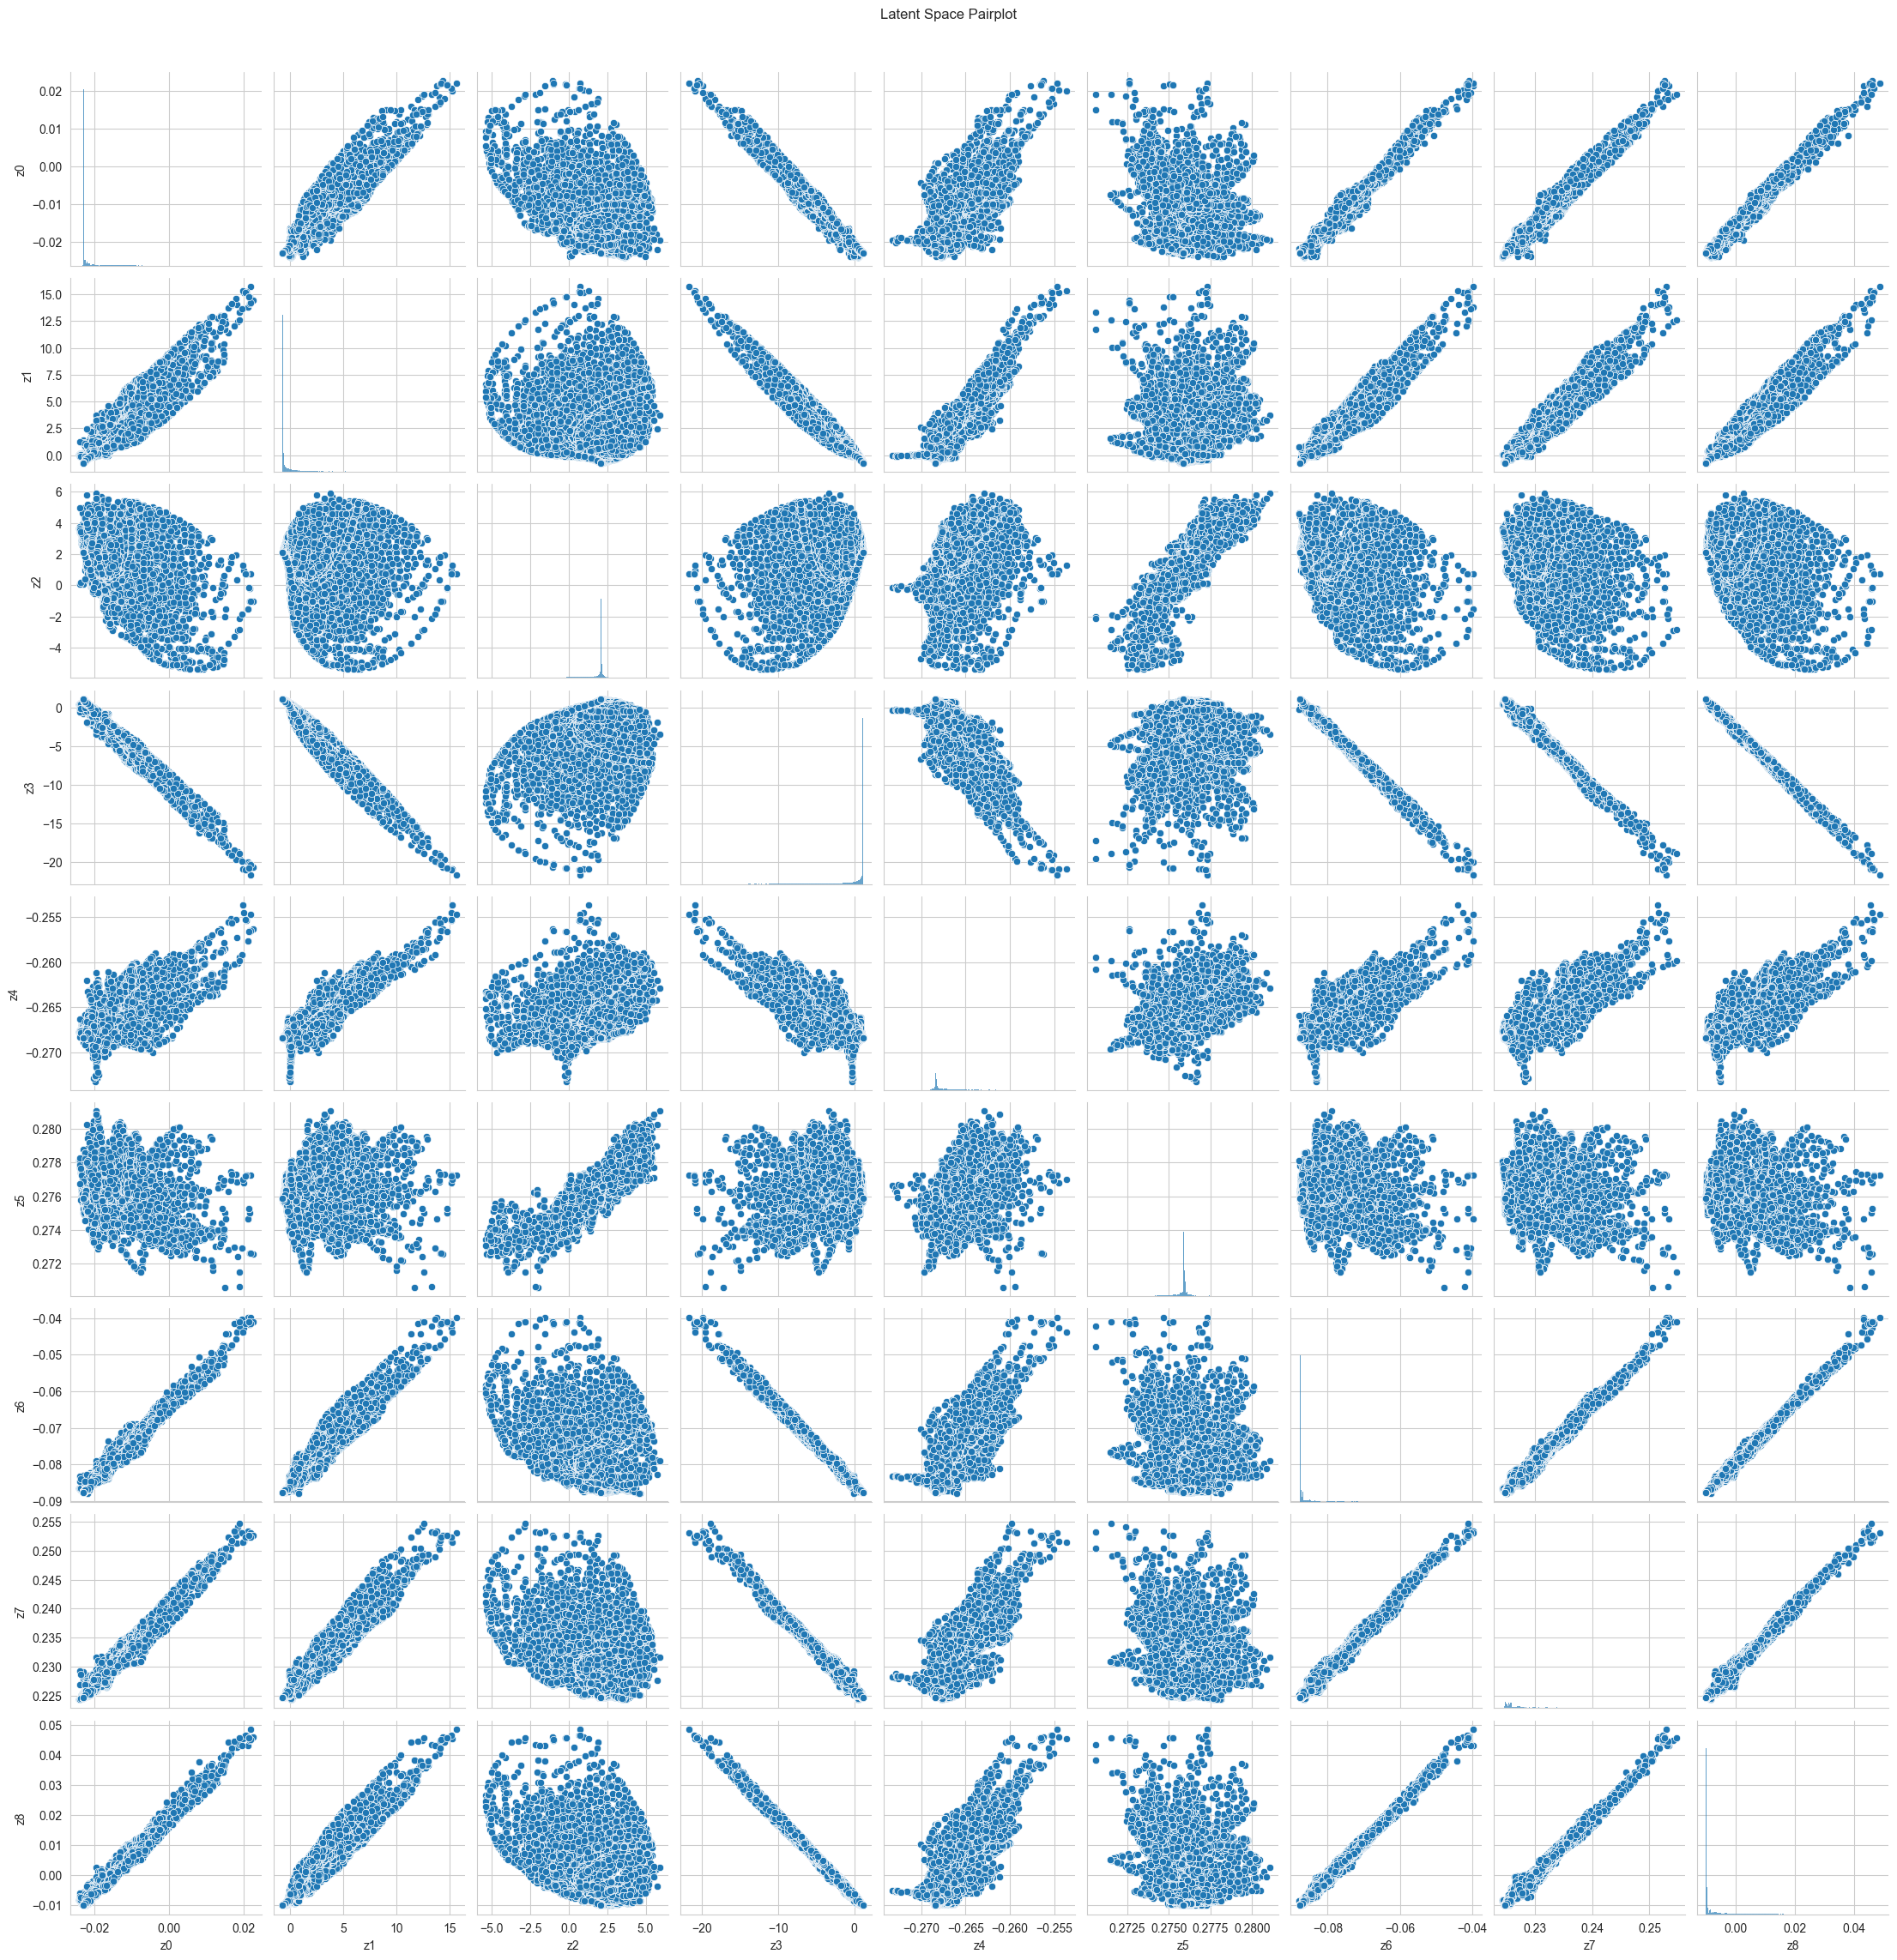

In [13]:
df_GLV = pd.DataFrame(z.cpu().detach().numpy(), columns=[f'z{i}' for i in range(z.shape[1])])
plt.figure()
sns.pairplot(df_GLV)
plt.suptitle('Latent Space Pairplot', y=1.02)
plt.show()

## Diffusion Maps

In [16]:
from pydiffmap import diffusion_map as dm
# initialize Diffusion map object.
neighbor_params = {'n_jobs': -1, 'algorithm': 'ball_tree'}

mydmap = dm.DiffusionMap.from_sklearn(n_evecs=2, k=200, epsilon='bgh', alpha=1.0, neighbor_params=neighbor_params)
# fit to data and return the diffusion map.
dmap = mydmap.fit_transform(X)

KeyboardInterrupt: 

In [ ]:
from pydiffmap.visualization import embedding_plot, data_plot

embedding_plot(mydmap, scatter_kwargs = {'c': dmap[:,0], 'cmap': 'Spectral'})
data_plot(mydmap, dim=3, scatter_kwargs = {'cmap': 'Spectral'})

plt.show()